In [1]:
# =====================
# Imports
# =====================
%load_ext line_profiler
import sys
sys.path.append('mister_ed')

from geocert import compute_boundary_batch, batch_GeoCert, incremental_GeoCert
import geocert_oop as geo
from plnn import PLNN
import _polytope_ as _poly_
from _polytope_ import Polytope, Face, from_polytope_dict
import utilities as utils
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
# from convex_adversarial import robust_loss

import adversarial_perturbations as ap 
import prebuilt_loss_functions as plf
import loss_functions as lf 
import adversarial_attacks as aa
import utils.pytorch_utils as me_utils

true_idxs = lambda arr: [i for i, el in enumerate(arr) if el]


/Users/jordanm/.virtualenvs/myvenv/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


===============Generating Training Points============
===============Points Generated============
===============Initializing Network============
Sequential(
  (1): Linear(in_features=2, out_features=10, bias=True)
  (2): ReLU()
  (3): Linear(in_features=10, out_features=50, bias=True)
  (4): ReLU()
  (5): Linear(in_features=50, out_features=10, bias=True)
  (6): ReLU()
  (7): Linear(in_features=10, out_features=2, bias=True)
)
===============Training Network with Regularization============
(0000) error:  tensor(0.5385)


/Users/jordanm/.virtualenvs/myvenv/lib/python3.7/site-packages/torch/tensor.py:263: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


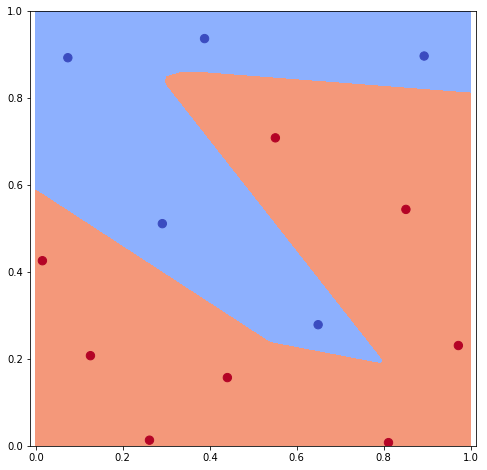

In [2]:
##########################################################
#               SET UP BABY NETWORK                      #
##########################################################

# apply incremental geocert to a normal and l1-regularized classifier. Finds maximal l_p balls
# for random points in R^2.

# ==================================
# Generate Training Points
# ==================================

print('===============Generating Training Points============')
# random points at least 2r apart
# 10d example: 
DIM = 2
m = 13
np.random.seed(3)
x = [np.random.uniform(size=(DIM))]
r = 0.16
while(len(x) < m):
    p = np.random.uniform(size=(DIM))
    if min(np.abs(p-a).sum() for a in x) > 2*r:
        x.append(p)
# r = 0.145
epsilon = r/2

X = torch.Tensor(np.array(x))
torch.manual_seed(1)
y = (torch.rand(m)+0.5).long()

print('===============Points Generated============')

# ==================================
# Initialize Network
# ==================================

print('===============Initializing Network============')
network = PLNN([DIM, 10, 50, 10, 2])
net = network.net


# ==================================
# Train Network
# ==================================

def l1_loss(net):

    return sum([_.norm(p=1) for _ in net.parameters() if _.dim() > 1])


print('===============Training Network with Regularization============')
opt = optim.Adam(net.parameters(), lr=1e-3)
for i in range(1000):
    out = net(Variable(X))
    l = nn.CrossEntropyLoss()(out, Variable(y)).view([1])
    l1_scale = torch.Tensor([1e-4])
    l += l1_scale * l1_loss(net).view([1])

    err = (out.max(1)[1].data != y).float().mean()
    opt.zero_grad()
    (l).backward()
    opt.step()
    if i % 1000 == 0:
        print('(%04d) error: ' % i, err)



# ==================================
# Visualize:  regularized classifier boundary
# ==================================
if DIM == 2:
    XX, YY = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
    X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
    y0 = network(X0)
    ZZ = (y0[:,0] - y0[:,1]).resize(100, 100).data.numpy()
    
    _, ax = plt.subplots(figsize=(8,8))
    ax.contourf(XX,YY,-ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))
    ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
    ax.axis("equal")
    ax.axis([0, 1, 0, 1])
    
    plt.show()

In [3]:
##################################################################
#               SET UP GEOCERT OBJECT                            #
##################################################################

save_dir = os.path.join(os.getcwd(), 'plots/oop_plnn_l2/')
geocert = geo.IncrementalGeoCert(network, verbose=True, display=False, save_dir=save_dir, 
                                 ax=None, config_fxn='parallel', use_clarkson=True)

test_point = torch.Tensor(np.array([0.25, 0.2]))
network(test_point)




tensor([[-4.9916,  5.2327]], grad_fn=<ThAddmmBackward>)

In [4]:
%lprun -f Polytope.generate_facets_configs_parallel geocert.min_dist(test_point.view(-1, 1), compute_upper_bound=True)


CWL2 found an upper bound of: 0.19298583269119263
---Initial Polytope---
Num facets:  4
REJECT DICT:  {'upper_bound': 60, 'infeasible': 6}
---Opening New Polytope---
Lower bound is  0.015273580530166933
Num facets:  1
REJECT DICT:  {'upper_bound': 60, 'infeasible': 8, 'shared': 1}
---Opening New Polytope---
Lower bound is  0.02932016300158691


/Users/jordanm/.virtualenvs/myvenv/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:1262: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  OptimizeWarning)
/Users/jordanm/.virtualenvs/myvenv/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:1274: OptimizeWarning: Solving system with option 'sym_pos':False failed. This may happen occasionally, especially as the solution is approached. However, if you see this frequently, your problem may be numerically challenging. If you cannot improve the formulation, consider setting 'lstsq' to True. Consider also setting `presolve` to True, if it is not already.
  OptimizeWarning)
/Users/jordanm/.virtualenvs/myvenv/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:1048: RuntimeWarning: internal gelsd driver lwork query error, required iwor

Num facets:  2
REJECT DICT:  {'upper_bound': 60, 'infeasible': 7, 'shared': 1}
---Opening New Polytope---
Lower bound is  0.03911100543971585


/Users/jordanm/.virtualenvs/myvenv/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:1262: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  OptimizeWarning)
/Users/jordanm/.virtualenvs/myvenv/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:1274: OptimizeWarning: Solving system with option 'sym_pos':False failed. This may happen occasionally, especially as the solution is approached. However, if you see this frequently, your problem may be numerically challenging. If you cannot improve the formulation, consider setting 'lstsq' to True. Consider also setting `presolve` to True, if it is not already.
  OptimizeWarning)
/Users/jordanm/.virtualenvs/myvenv/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:1048: RuntimeWarning: internal gelsd driver lwork query error, required iwor

Num facets:  4
REJECT DICT:  {'upper_bound': 60, 'infeasible': 5, 'shared': 1}
---Opening New Polytope---
Lower bound is  0.04755930408312351
Num facets:  2
REJECT DICT:  {'upper_bound': 60, 'infeasible': 7, 'shared': 1}
---Opening New Polytope---
Lower bound is  0.056761603294902936


/Users/jordanm/.virtualenvs/myvenv/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:1262: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  OptimizeWarning)
/Users/jordanm/.virtualenvs/myvenv/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:1274: OptimizeWarning: Solving system with option 'sym_pos':False failed. This may happen occasionally, especially as the solution is approached. However, if you see this frequently, your problem may be numerically challenging. If you cannot improve the formulation, consider setting 'lstsq' to True. Consider also setting `presolve` to True, if it is not already.
  OptimizeWarning)
/Users/jordanm/.virtualenvs/myvenv/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:1048: RuntimeWarning: internal gelsd driver lwork query error, required iwor

Num facets:  4
REJECT DICT:  {'upper_bound': 61, 'infeasible': 4, 'shared': 1}
---Opening New Polytope---
Lower bound is  0.061638806071402825


/Users/jordanm/.virtualenvs/myvenv/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:1262: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  OptimizeWarning)
/Users/jordanm/.virtualenvs/myvenv/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:1274: OptimizeWarning: Solving system with option 'sym_pos':False failed. This may happen occasionally, especially as the solution is approached. However, if you see this frequently, your problem may be numerically challenging. If you cannot improve the formulation, consider setting 'lstsq' to True. Consider also setting `presolve` to True, if it is not already.
  OptimizeWarning)
/Users/jordanm/.virtualenvs/myvenv/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:1048: RuntimeWarning: internal gelsd driver lwork query error, required iwor

Num facets:  3
REJECT DICT:  {'upper_bound': 61, 'infeasible': 5, 'shared': 1}
---Opening New Polytope---
Lower bound is  0.06347768665325781


/Users/jordanm/.virtualenvs/myvenv/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:1262: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  OptimizeWarning)
/Users/jordanm/.virtualenvs/myvenv/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:1274: OptimizeWarning: Solving system with option 'sym_pos':False failed. This may happen occasionally, especially as the solution is approached. However, if you see this frequently, your problem may be numerically challenging. If you cannot improve the formulation, consider setting 'lstsq' to True. Consider also setting `presolve` to True, if it is not already.
  OptimizeWarning)
/Users/jordanm/.virtualenvs/myvenv/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:1048: RuntimeWarning: internal gelsd driver lwork query error, required iwor

Num facets:  2
REJECT DICT:  {'upper_bound': 60, 'infeasible': 6, 'shared': 2}
---Opening New Polytope---
Lower bound is  0.06347802785361747
We've already seen that polytope
---Opening New Polytope---
Lower bound is  0.08841012314558844
Num facets:  1
REJECT DICT:  {'upper_bound': 61, 'infeasible': 6, 'shared': 2}
---Opening New Polytope---
Lower bound is  0.08841022498766468
We've already seen that polytope
---Opening New Polytope---
Lower bound is  0.09476198169474516
Num facets:  3
REJECT DICT:  {'upper_bound': 61, 'infeasible': 4, 'shared': 2}
---Opening New Polytope---
Lower bound is  0.0947620457352423
We've already seen that polytope
---Opening New Polytope---
Lower bound is  0.0991147825114154


/Users/jordanm/.virtualenvs/myvenv/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:1262: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  OptimizeWarning)
/Users/jordanm/.virtualenvs/myvenv/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:1274: OptimizeWarning: Solving system with option 'sym_pos':False failed. This may happen occasionally, especially as the solution is approached. However, if you see this frequently, your problem may be numerically challenging. If you cannot improve the formulation, consider setting 'lstsq' to True. Consider also setting `presolve` to True, if it is not already.
  OptimizeWarning)
/Users/jordanm/.virtualenvs/myvenv/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:1048: RuntimeWarning: internal gelsd driver lwork query error, required iwor

Num facets:  3
REJECT DICT:  {'upper_bound': 61, 'infeasible': 5, 'shared': 1}
---Opening New Polytope---
Lower bound is  0.10424548613591525


/Users/jordanm/.virtualenvs/myvenv/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:1262: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  OptimizeWarning)
/Users/jordanm/.virtualenvs/myvenv/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:1274: OptimizeWarning: Solving system with option 'sym_pos':False failed. This may happen occasionally, especially as the solution is approached. However, if you see this frequently, your problem may be numerically challenging. If you cannot improve the formulation, consider setting 'lstsq' to True. Consider also setting `presolve` to True, if it is not already.
  OptimizeWarning)
/Users/jordanm/.virtualenvs/myvenv/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:1048: RuntimeWarning: internal gelsd driver lwork query error, required iwor

Num facets:  1
REJECT DICT:  {'upper_bound': 61, 'infeasible': 6, 'shared': 2}
---Opening New Polytope---
Lower bound is  0.10424548722318522
We've already seen that polytope
---Opening New Polytope---
Lower bound is  0.10843122700912194


/Users/jordanm/.virtualenvs/myvenv/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:1262: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  OptimizeWarning)
/Users/jordanm/.virtualenvs/myvenv/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:1274: OptimizeWarning: Solving system with option 'sym_pos':False failed. This may happen occasionally, especially as the solution is approached. However, if you see this frequently, your problem may be numerically challenging. If you cannot improve the formulation, consider setting 'lstsq' to True. Consider also setting `presolve` to True, if it is not already.
  OptimizeWarning)
/Users/jordanm/.virtualenvs/myvenv/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:1048: RuntimeWarning: internal gelsd driver lwork query error, required iwor

Num facets:  0
REJECT DICT:  {'upper_bound': 60, 'infeasible': 8, 'shared': 2}
---Opening New Polytope---
Lower bound is  0.10843142456935292
We've already seen that polytope
---Opening New Polytope---
Lower bound is  0.11538563574182992


/Users/jordanm/.virtualenvs/myvenv/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:1262: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  OptimizeWarning)
/Users/jordanm/.virtualenvs/myvenv/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:1274: OptimizeWarning: Solving system with option 'sym_pos':False failed. This may happen occasionally, especially as the solution is approached. However, if you see this frequently, your problem may be numerically challenging. If you cannot improve the formulation, consider setting 'lstsq' to True. Consider also setting `presolve` to True, if it is not already.
  OptimizeWarning)
/Users/jordanm/.virtualenvs/myvenv/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:1048: RuntimeWarning: internal gelsd driver lwork query error, required iwor

Num facets:  2
REJECT DICT:  {'upper_bound': 61, 'infeasible': 6, 'shared': 1}
---Opening New Polytope---
Lower bound is  0.13500693978886444


/Users/jordanm/.virtualenvs/myvenv/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:1262: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  OptimizeWarning)
/Users/jordanm/.virtualenvs/myvenv/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:1274: OptimizeWarning: Solving system with option 'sym_pos':False failed. This may happen occasionally, especially as the solution is approached. However, if you see this frequently, your problem may be numerically challenging. If you cannot improve the formulation, consider setting 'lstsq' to True. Consider also setting `presolve` to True, if it is not already.
  OptimizeWarning)
/Users/jordanm/.virtualenvs/myvenv/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:1048: RuntimeWarning: internal gelsd driver lwork query error, required iwor

Num facets:  1
REJECT DICT:  {'upper_bound': 61, 'infeasible': 7, 'shared': 1}
---Opening New Polytope---
Lower bound is  0.14006350572560897


/Users/jordanm/.virtualenvs/myvenv/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:1262: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  OptimizeWarning)
/Users/jordanm/.virtualenvs/myvenv/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:1274: OptimizeWarning: Solving system with option 'sym_pos':False failed. This may happen occasionally, especially as the solution is approached. However, if you see this frequently, your problem may be numerically challenging. If you cannot improve the formulation, consider setting 'lstsq' to True. Consider also setting `presolve` to True, if it is not already.
  OptimizeWarning)
/Users/jordanm/.virtualenvs/myvenv/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:1048: RuntimeWarning: internal gelsd driver lwork query error, required iwor

Num facets:  1
REJECT DICT:  {'upper_bound': 61, 'infeasible': 6, 'shared': 2}
---Opening New Polytope---
Lower bound is  0.14006352792609691
We've already seen that polytope
---Opening New Polytope---
Lower bound is  0.14848538321974486


/Users/jordanm/.virtualenvs/myvenv/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:1262: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  OptimizeWarning)
/Users/jordanm/.virtualenvs/myvenv/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:1274: OptimizeWarning: Solving system with option 'sym_pos':False failed. This may happen occasionally, especially as the solution is approached. However, if you see this frequently, your problem may be numerically challenging. If you cannot improve the formulation, consider setting 'lstsq' to True. Consider also setting `presolve` to True, if it is not already.
  OptimizeWarning)
/Users/jordanm/.virtualenvs/myvenv/lib/python3.7/site-packages/scipy/optimize/_linprog_ip.py:1048: RuntimeWarning: internal gelsd driver lwork query error, required iwor

Num facets:  0
REJECT DICT:  {'upper_bound': 61, 'shared': 2, 'infeasible': 7}
---Opening New Polytope---
Lower bound is  0.14848552108048696
We've already seen that polytope
----------Minimal Projection Generated----------
DIST:  0.18850237577774312


In [5]:
uba = np.array([[-1.15312, -0.90686],
                [-1.14678, -0.90665],
                [-1.14872, -0.90603],
                [-1.15559, -0.89766]])
ubb = np.array([-1., -1., -1., -1.])

p = Polytope(uba, ubb)
p._interior_point()
p.interior_point

UNBOUNDED INTERIOR POINT: 4 2 [ 0.  0. -1.] [2.23606e+09 1.62982e+09 1.99857e+09]


array([2.23606e+09, 1.62982e+09])

In [6]:
import time
def timeit(inputs):
    # Keeps track of a list of triples: (CW bound, Real bound, time to run)
    outputs = []
    for input_point in inputs:
        try:
            start = time.time() 
            real, cw = geocert.min_dist(input_point, compute_upper_bound=True)
            end = time.time() 
            outputs.append((cw, real, end - start))
        except Exception as err:
            print(err)
            pass 
    return outputs
        


In [ ]:
geo.IncrementalGeoCert